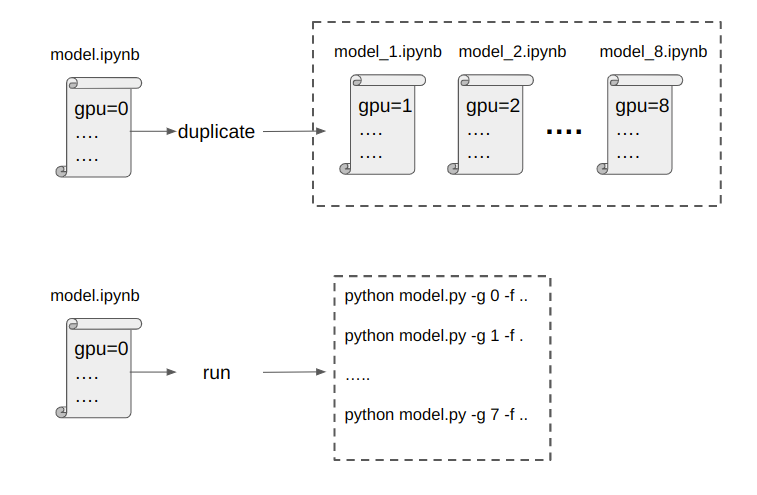

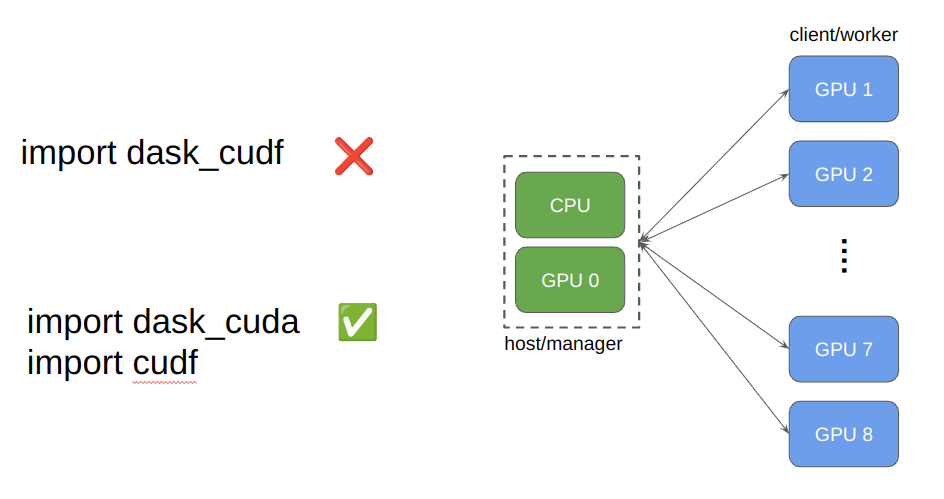

```








```

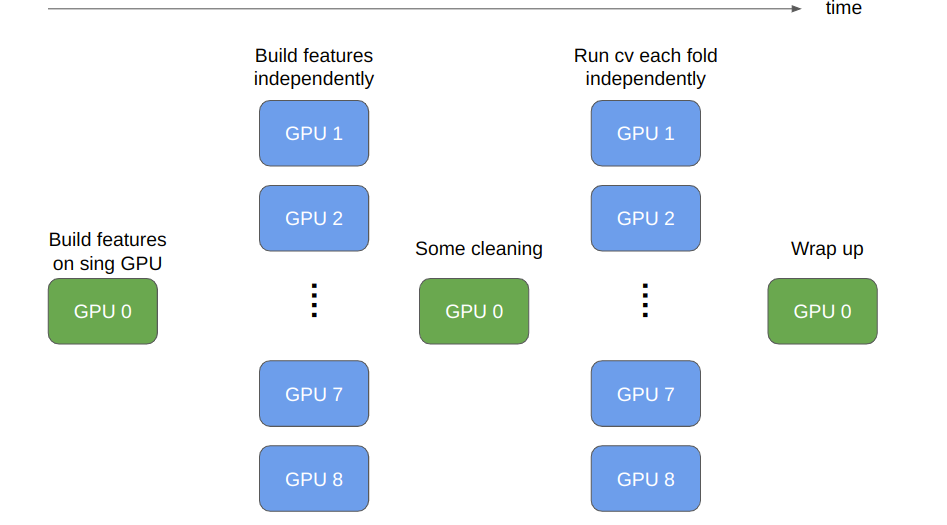

In [1]:
import os

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import cudf
from dask.distributed import Client
from dask_cuda import LocalCUDACluster
import gc
import subprocess
from tqdm import tqdm

In [4]:
cudf.__version__

'22.12.01'

In [5]:
def get_ip():
    cmd = "hostname --all-ip-addresses"
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    output, error = process.communicate()
    IPADDR = str(output.decode()).split()[0]
    print(IPADDR)
    return IPADDR

Unfortunately, what we tried to do here is not supported by UCX

In [6]:
def get_client(gpus):
    ip = get_ip()
    cluster = LocalCUDACluster(CUDA_VISIBLE_DEVICES=gpus,
                               ip=ip)
    client = Client(cluster,name=f'GPU {gpus}')
    return client

In [7]:
gpu1 = get_client('1')
gpu2 = get_client('2')
gpu3 = get_client('3')

100.96.201.45


2023-02-28 16:56:55,581 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-02-28 16:56:55,581 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize


100.96.201.45


2023-02-28 16:56:58,435 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-02-28 16:56:58,435 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize


100.96.201.45


2023-02-28 16:57:01,369 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-02-28 16:57:01,370 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize


In [8]:
gpu1

Connection method: Cluster object,Cluster type: dask_cuda.LocalCUDACluster
Dashboard: http://100.96.201.45:8787/status,
Dashboard: http://100.96.201.45:8787/status,Workers: 1
Total threads: 1,Total memory: 200.00 GiB
Status: running,Using processes: True
Comm: tcp://100.96.201.45:41449,Workers: 1
Dashboard: http://100.96.201.45:8787/status,Total threads: 1
Started: Just now,Total memory: 200.00 GiB
Comm: tcp://100.96.201.45:35189,Total threads: 1
Dashboard: http://100.96.201.45:44903/status,Memory: 200.00 GiB
Nanny: tcp://100.96.201.45:38735,


In [9]:
gpu2

Connection method: Cluster object,Cluster type: dask_cuda.LocalCUDACluster
Dashboard: http://100.96.201.45:39169/status,
Dashboard: http://100.96.201.45:39169/status,Workers: 1
Total threads: 1,Total memory: 200.00 GiB
Status: running,Using processes: True
Comm: tcp://100.96.201.45:36775,Workers: 1
Dashboard: http://100.96.201.45:39169/status,Total threads: 1
Started: Just now,Total memory: 200.00 GiB
Comm: tcp://100.96.201.45:38989,Total threads: 1
Dashboard: http://100.96.201.45:43227/status,Memory: 200.00 GiB
Nanny: tcp://100.96.201.45:35835,


In [10]:
PATH = '/raid/data/ml/kaggle/amex'

In [11]:
os.listdir(PATH)

['train_labels.csv',
 'processed',
 'models',
 'test.parquet',
 'train_labels.csv.zip',
 'amex-data-integer-dtypes-parquet-format.zip',
 'train.parquet']

In [12]:
%%time

train = cudf.read_parquet(f'{PATH}/train.parquet')
print(train.shape)
display(train.head())

(5531451, 190)


,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0,0.008724,1.006838,0.009228,0.124035,0.0,0.004709,...,-1,-1,-1,0,0,0.0,<NA>,0,0.000610,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0,0.004923,1.000653,0.006151,0.126750,0.0,0.002714,...,-1,-1,-1,0,0,0.0,<NA>,0,0.005492,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,3,0.021655,1.009672,0.006815,0.123977,0.0,0.009423,...,-1,-1,-1,0,0,0.0,<NA>,0,0.006986,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0,0.013683,1.002700,0.001373,0.117169,0.0,0.005531,...,-1,-1,-1,0,0,0.0,<NA>,0,0.006527,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947248,0,0.015193,1.000727,0.007605,0.117325,0.0,0.009312,...,-1,-1,-1,0,0,0.0,<NA>,0,0.008126,0


CPU times: user 2.26 s, sys: 1.01 s, total: 3.27 s
Wall time: 3.03 s


### Get last profile

In [13]:
def get_num_cols(train):
    cat_cols = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120','D_126', 'D_63', 'D_64', 'D_66', 'D_68']
    not_used = [i for i in train.columns if i in ['cid','target','S_2']+cat_cols or train[i].dtype=='O']
    num_cols = [col for col in train.columns if col not in not_used]
    return num_cols

In [14]:
%%time

def get_last_profile(df):
    df['cid'], _ = df.customer_ID.factorize()
    df['S_2'] = cudf.to_datetime(df['S_2'])
    df = df.sort_values(['cid','S_2'])
    df = df.drop_duplicates('cid',keep='last')
    df = df.sort_values('cid')
    return df

train_last = get_last_profile(train)
train_label = cudf.read_csv(f'{PATH}/train_labels.csv')
train_last = train_last.merge(train_label,on='customer_ID',how='left')
num_cols = get_num_cols(train)
train_last = train_last[num_cols+['cid','target']]
train_last = train_last.set_index('cid')
display(train_last.head())
train_last.to_parquet(f'{PATH}/processed/train_last.parquet')

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
cid,,,,,,,,,,,,,,,,,,,,,
2512,0.530060,0,0.008406,0.815427,0.005535,0.363221824,0.0,0.001157,<NA>,0.133505866,...,-1,-1,0,0,0.0,<NA>,0,0.008841,0,0
2513,0.753330,13,0.029849,1.004544,0.001573,0.053374525,0.0,0.002529,<NA>,0.0481111,...,-1,-1,0,0,0.0,<NA>,0,0.004034,0,0
2514,0.823920,8,0.116503,0.161849,0.002850,0.115643799,0.0,0.166192,<NA>,0.031689435,...,-1,-1,0,0,0.0,<NA>,0,0.007439,0,0
2515,0.716999,13,0.482553,0.027762,0.006957,0.14822267,0.0,0.148544,<NA>,0.240245864,...,-1,-1,0,0,0.0,<NA>,0,0.008052,0,0
2516,0.544771,0,0.008951,0.819092,0.500895,<NA>,0.0,0.003747,<NA>,<NA>,...,-1,-1,0,0,0.0,<NA>,0,0.005776,0,0


CPU times: user 2.06 s, sys: 1.11 s, total: 3.17 s
Wall time: 3.02 s


### Compute stats

In [15]:
def compute_stats(df, cols):
    stats = ['mean','std']
    dg = df.groupby('cid').agg({col:stats for col in cols})
    out_cols = []
    for col in cols:
        out_cols.extend([f'{col}_{s}' for s in stats])
    dg.columns = out_cols
    return dg

In [16]:
%%time
num_cols = get_num_cols(train)
train_stats = compute_stats(train, num_cols)
display(train_stats.head())
train_stats.to_parquet(f'{PATH}/processed/train_stats.parquet')

,P_2_mean,P_2_std,D_39_mean,D_39_std,B_1_mean,B_1_std,B_2_mean,B_2_std,R_1_mean,R_1_std,...,D_141_mean,D_141_std,D_142_mean,D_142_std,D_143_mean,D_143_std,D_144_mean,D_144_std,D_145_mean,D_145_std
cid,,,,,,,,,,,,,,,,,,,,,
285589,0.684089,0.019880,6.076923,8.410921,0.031904,0.026345,0.962512,0.083588,0.004058,0.003181,...,0.0,0.0,<NA>,<NA>,0.0,0.0,0.003589,0.002057,0.0,0.0
257134,0.393237,0.284383,9.384615,10.966148,0.132745,0.117185,0.470085,0.452514,0.273831,0.387846,...,0.0,0.0,<NA>,<NA>,0.0,0.0,0.004534,0.003592,0.0,0.0
291696,0.703240,0.014884,14.538462,9.963395,0.598905,0.335177,0.138262,0.219087,0.005149,0.002694,...,0.0,0.0,<NA>,<NA>,0.0,0.0,0.003239,0.002883,0.0,0.0
150195,0.570092,0.089175,3.307692,6.088029,0.418496,0.440194,0.321061,0.413808,0.158696,0.240584,...,0.0,0.0,<NA>,<NA>,0.0,0.0,0.005645,0.003490,0.0,0.0
455841,0.851675,0.049740,4.692308,5.170181,0.054456,0.030462,0.455502,0.441308,0.043774,0.137942,...,0.0,0.0,<NA>,<NA>,0.0,0.0,0.006180,0.003482,0.0,0.0


CPU times: user 1.92 s, sys: 2.72 s, total: 4.63 s
Wall time: 4.49 s


### Compute diff cols and then compute their stats

we define a function that will be dispatched to run on other GPUs:
- due to the PCIE bandwidth limit, the input data of the funcation should be small
- for big input data, read them from disk
- similarly, small results can be returned directly while big results should be writen to disk

In [20]:
def compute_diff_stats(cols,tag):
    train = cudf.read_parquet(f'{PATH}/train.parquet')
    train['cid'], _ = train.customer_ID.factorize()
    ncols = []
    for col in cols:
        train[f'{col}_diff'] = train.groupby('cid')[col].diff()
        ncols.append(f'{col}_diff')
    train = compute_stats(train, ncols)
    train.to_parquet(f'{PATH}/processed/train_diff_{tag}.parquet')

divide columns into 4 groups with similar size

In [21]:
N = len(num_cols)
step = N//4
col_groups = []
for i in range(0, N, step):
    e = min(i+step, N)
    if N-e < step:
        e = N
    col_groups.append(num_cols[i:e])
    if e == N:
        break

In [22]:
[len(i) for i in col_groups]

[44, 44, 44, 45]

`client.submit` is an async op.

In [23]:
%%time
f1 = gpu1.submit(compute_diff_stats, col_groups[1], 'part_1')
f2 = gpu2.submit(compute_diff_stats, col_groups[2], 'part_2')
f3 = gpu3.submit(compute_diff_stats, col_groups[3], 'part_3')

CPU times: user 31.9 ms, sys: 3.51 ms, total: 35.4 ms
Wall time: 33.4 ms


In [24]:
f1

<Future: finished, type: NoneType, key: compute_diff_stats-1e0d12885315683d36be4d25867f8996>

In [25]:
f1.result()

In [26]:
os.listdir(f'{PATH}/processed/')

['train_diff_part_2.parquet',
 'train_diff_part_3.parquet',
 'train_diff_part_1.parquet',
 'train_last.parquet',
 'train_stats.parquet',
 'train_diff_part_0.parquet']

In [27]:
%%time
compute_diff_stats(col_groups[0],'part_0')

CPU times: user 3.74 s, sys: 1.91 s, total: 5.64 s
Wall time: 6.26 s


In [28]:
%%time
f1.result(), f2.result(), f3.result()

CPU times: user 9.75 ms, sys: 2.77 ms, total: 12.5 ms
Wall time: 14.8 ms


(None, None, None)

In [29]:
del train, train_stats, train_last
gc.collect()

12051

In [31]:
import xgboost as xgb
from utils import amex_metric_np

def get_xgb_model():
    max_depth = 7
    num_trees = 1000
    early_stop = xgb.callback.EarlyStopping(rounds=10,
                                            maximize=True,
                                            metric_name='amex_metric_np',
                                            data_name='validation_0')
    model = xgb.XGBClassifier(
            tree_method='gpu_hist',
            enable_categorical=False,
            use_label_encoder=False,
            predictor='gpu_predictor',
            #eval_metric='auc',
            objective='binary:logistic',
            max_depth=max_depth,
            n_estimators=num_trees,
            #colsample_bytree=0.5,
            min_child_weight=50,
            eval_metric=amex_metric_np,
            callbacks=[early_stop]
            #gamma=10,
    )
    return model

def cv(num_folds, fold):
    trs = []
    trs.append(cudf.read_parquet(f'{PATH}/processed/train_last.parquet'))
    trs.append(cudf.read_parquet(f'{PATH}/processed/train_stats.parquet'))
    for p in range(4):
        trs.append(cudf.read_parquet(f'{PATH}/processed/train_diff_part_{p}.parquet'))
    train = cudf.concat(trs,axis=1)
    
    train = train.reset_index()
    
    mask = train['cid']%num_folds == fold
    va = train.loc[mask]
    tr = train.loc[~mask]
    
    model = get_xgb_model()
    model.fit(
            tr.drop(['cid','target'],axis=1),
            tr['target'],
            eval_set=[(va.drop(['cid','target'],axis=1), va['target'])],
            verbose=100
        )
    model.save_model(f'{PATH}/models/xgboost_{fold}.model')
    return model.best_score

Run folds 1,2,3 and GPU 1,2,3 respectively

In [32]:
%%time
f1 = gpu1.submit(cv, 4, 1)
f2 = gpu2.submit(cv, 4, 2)
f3 = gpu3.submit(cv, 4, 3)

CPU times: user 69.4 ms, sys: 27.3 ms, total: 96.7 ms
Wall time: 94.2 ms


Run fold 0 on GPU 0

In [33]:
%%time
cv(4,0)

/opt/conda/envs/rapids/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/opt/conda/envs/rapids/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/opt/conda/envs/rapids/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[0]	validation_0-logloss:0.52294	validation_0-amex_metric_np:0.71173
[0]	validation_0-logloss:0.52269	validation_0-amex_metric_np:0.71445
[0]	validation_0-logloss:0.52277	validation_0-amex_metric_np:0.71085
[0]	validation_0-logloss:0.52256	validation_0-amex_metric_np:0.71643
[46]	validation_0-logloss:0.22573	validation_0-amex_metric_np:0.77804


/opt/conda/envs/rapids/lib/python3.9/site-packages/xgboost/sklearn.py:761: UserWarning: eval_metric is not saved in Scikit-Learn meta.
  warnings.warn(
/opt/conda/envs/rapids/lib/python3.9/site-packages/xgboost/sklearn.py:761: UserWarning: callbacks is not saved in Scikit-Learn meta.
  warnings.warn(


[56]	validation_0-logloss:0.22365	validation_0-amex_metric_np:0.78239
[69]	validation_0-logloss:0.22517	validation_0-amex_metric_np:0.77911
CPU times: user 10.4 s, sys: 5.25 s, total: 15.6 s
Wall time: 21.1 s


/opt/conda/envs/rapids/lib/python3.9/site-packages/xgboost/sklearn.py:761: UserWarning: eval_metric is not saved in Scikit-Learn meta.
  warnings.warn(
/opt/conda/envs/rapids/lib/python3.9/site-packages/xgboost/sklearn.py:761: UserWarning: callbacks is not saved in Scikit-Learn meta.
  warnings.warn(
/opt/conda/envs/rapids/lib/python3.9/site-packages/xgboost/sklearn.py:761: UserWarning: eval_metric is not saved in Scikit-Learn meta.
  warnings.warn(
/opt/conda/envs/rapids/lib/python3.9/site-packages/xgboost/sklearn.py:761: UserWarning: callbacks is not saved in Scikit-Learn meta.
  warnings.warn(


0.783254

[61]	validation_0-logloss:0.22279	validation_0-amex_metric_np:0.78387


In [34]:
%%time
f1.result(),f2.result(),f3.result()

CPU times: user 13.6 ms, sys: 357 µs, total: 14 ms
Wall time: 15.2 ms


(0.784463, 0.780092, 0.780067)

In [29]:
xgb.__version__

'1.7.4'

In [35]:
os.listdir(f'{PATH}/models')

['xgboost_2.model', 'xgboost_3.model', 'xgboost_0.model', 'xgboost_1.model']